In [1]:
"""
安装pySWATPlus
   SPOTPY
   mpi4py
   MS mpi

0、pySWATPlus 下载rar解压，用anaconda prompt界面cd到解压的文件夹，用pytohn setup.py install安装

一、TxtinoutReader
1.必须指定工作路径，否则工作路径会变成copy里的路径
2.必须使用绝对路径
3.网页教程的参数格式不对
4.改变参数，不指定行id时，用 None

二、FileReader
1.读取文件不指定index时，必须用None,不可省略
2.usecols省略的话，读取的df为空

三、定义SWAT函数给SPOTPY用时注意以下几点
1、SWAT模型的参数定义不要超过上下界，如(0, 1)用(0.001, 0.999)代替
2、用pySWATPlus定义函数给simulation用时，尽量把只修改一次文件的语句放函数外面
   例如， reader.set_beginning_and_end_year(2017, 2018)
         reader.set_warmup(1)
         reader.enable_object_in_print_prt("channel_sd", True, False, False, False)
   这些直接在root文件夹里手动改就行，不要写成代码，因为用mpiexec并行处理时，会导致文件被意想不到的修改
"""
%reset -f
import os
import pandas as pd
import numpy as np
import spotpy as sp
import shutil
import mpi4py
import sys
from pySWATPlus.TxtinoutReader import TxtinoutReader
from pySWATPlus.FileReader import FileReader
from matplotlib import pyplot as plt
from datetime import datetime
cwd = "E:/SPOTPY-and-pySWATPlus"

# 用pySWATPlus定义huron_swat函数

In [2]:
def huron_swat(reader, params, copy_path, show_output=False, delete_copy=True):
    result = reader.copy_and_run(dir=copy_path,
                                 params=params,
                                 show_output=show_output
                                 )
    reader = FileReader(os.path.join(result, "channel_sd_day.txt"),
                        has_units = True,
                        index=None,
                        usecols=["mon", "day", "yr", "unit", "flo_out"],
                        filter_by={"unit": 1}
                        )
    res = reader.df
    res["Date"] = pd.to_datetime(pd.DataFrame({"year": res["yr"],
                                               "month": res["mon"],
                                               "day": res["day"]}))
    res.drop(columns=["mon", "day", "yr", "unit"], inplace=True)
    if delete_copy:
        shutil.rmtree(result, ignore_errors=True)
    os.chdir(cwd) #改回当前路径
    return res

# 定义SPOTPY类

In [3]:
class spot_swat():
    def __init__(self, TxtInOut_abspath, copy_path, start_print, end_print,
                 prior=sp.parameter.Uniform, obj_func=None,
                 show_output=False, delete_copy=True):
        self.reader = TxtinoutReader(TxtInOut_abspath)
        self.copy_path = copy_path
        self.start = start_print
        self.end = end_print
        self.obj_func = obj_func
        self.show_output = show_output
        self.delete_copy = delete_copy
    
        self.params = [prior("lat_ttime",0.51, 179.0, optguess = 39.70),
                       prior("can_max",0.01, 99.9, optguess = 89.84),
                       prior("esco",0.01,0.99, optguess = 0.018),
                       prior("epco",0.01, 0.99, optguess = 0.243),
                       prior("cn3_swf",0.01, 0.99, optguess = 0.613),
                       prior("perco",0.01, 0.99, optguess = 0.705),
                       prior("pet_co",0.71, 1.29, optguess = 0.79),
                       prior("latq_co",0.01, 0.99, optguess = 0.945),
                       prior("cn_a",30.0, 70.0, optguess = 49.2),
                       prior("cn_b",50.0, 80.0, optguess = 62.2),
                       prior("cn_c",70.0, 90.0, optguess = 89.3),
                       prior("cn_d",80.0, 95.0, optguess = 90.5),
                       prior("gw_flo",0.0, 2.0, optguess = 1.80),
                       prior("dep_bot",5.0, 50.0, optguess = 27.5),
                       prior("dep_wt",2.0, 20.0, optguess = 18.6),
                       prior("flo_dist",10.0, 200.0, optguess = 76.6),
                       prior("bf_max",0.11, 1.99, optguess =  1.49),
                       prior("alpha_bf",0.01, 0.99, optguess =  0.812),
                       prior("revap",0.021, 0.199, optguess = 0.119),
                       prior("rchg_dp",0.001, 0.100, optguess = 0.014),
                       prior("spec_yld",0.01, 0.49, optguess = 0.454),
                       prior("flo_min",0.1, 49.0, optguess = 23.9),
                       prior("revap_min",0.1, 49.0, optguess = 45.1),
                       prior("fall_tmp",-4.9, 4.9, optguess = -4.76),
                       prior("melt_tmp",-4.9, 4.9, optguess = 0.87),
                       prior("melt_max_min",0.1, 9.9, optguess = 9.28),
                       prior("melt_lag",0.01, 0.99, optguess = 0.253),
                       prior("snow_h2o",0.1, 499.9, optguess = 299.7),
                       prior("cov50",0.01, 0.90, optguess = 0.623),
                       prior("dp",0.1, 5999.9, optguess = 642.6),
                       prior("t_fc",0.1, 99.9, optguess = 9.45),
                       prior("lag",0.1, 99.9, optguess = 23.5),
                       prior("rad",3.1, 39.9, optguess = 21.0),
                       prior("dist",7601, 29999, optguess = 10673.9),
                       prior("drain",10.1, 50.9, optguess = 16.6),
                       prior("pump",0.1, 9.9, optguess = 8.80),
                       prior("lat_kast",0.02, 3.99, optguess = 3.82),
                       prior("lai_noevap",0.1, 9.9, optguess = 7.75),
                       prior("sw_init",0.01, 0.99, optguess = 0.021),
                       prior("surq_lag",1.1, 23.9, optguess = 13.1),
                       prior("msk_co1",0.1, 9.9, optguess = 2.49),
                       prior("msk_co2",0.1, 9.9, optguess = 5.99),
                       prior("msk_x",0.01, 0.29, optguess = 0.068),
                       prior("evap_adj",0.51, 0.99, optguess = 0.685),
                       prior("scoef",0.01, 0.99, optguess = 0.882),
                       prior("surq_exp",1.1, 2.9, optguess =  1.61),
                       ]
    def parameters(self):
        return sp.parameter.generate(self.params)

    def simulation(self, vector):
        par = np.array(vector)
        swat_params = {"hydrology.hyd":("name", [(None,"lat_ttime", par[0]),
                                                 (None,"can_max", par[1]),
                                                 (None,"esco", par[2]),
                                                 (None,"epco", par[3]),
                                                 (None,"cn3_swf", par[4]),
                                                 (None,"perco", par[5]),
                                                 (None,"pet_co", par[6]),
                                                 (None,"latq_co", par[7]),
                                                 ],
                                        ),
                       "cntable.lum":("description", [(None,"cn_a", par[8]),
                                                      (None,"cn_b", par[9]),
                                                      (None,"cn_c", par[10]),
                                                      (None,"cn_d", par[11]),
                                                      ],
                                      ),
                       "aquifer.aqu":("name", [(None, "gw_flo", par[12]),
                                               (None, "dep_bot", par[13]),
                                               (None, "dep_wt", par[14]),
                                               (None, "flo_dist", par[15]),
                                               (None, "bf_max", par[16]),
                                               (None, "alpha_bf", par[17]),
                                               (None, "revap", par[18]),
                                               (None, "rchg_dp", par[19]),
                                               (None, "spec_yld", par[20]),
                                               (None, "flo_min", par[21]),
                                               (None, "revap_min", par[22]),
                                              ],
                                      ),
                       "snow.sno":("name", [(None, "fall_tmp", par[23]),
                                            (None, "melt_tmp", par[24]),
                                            (None, "melt_max", par[25]),
                                            (None, "melt_min", par[25]),
                                            (None, "tmp_lag", par[26]),
                                            (None, "snow_h2o", par[27]),
                                            (None, "cov50", par[28]),
                                           ],
                                   ),
                       "tiledrain.str":("name", [(None, "dp", par[29]),
                                                 (None, "t_fc", par[30]),
                                                 (None, "lag", par[31]),
                                                 (None, "rad", par[32]),
                                                 (None, "dist", par[33]),
                                                 (None, "drain", par[34]),
                                                 (None, "pump", par[35]),
                                                 (None, "lat_ksat", par[36]),
                                                ],
                                        ),
                       "parameters.bsn":("igen", [(None, "lai_noevap", par[37]),
                                                  (None, "sw_init", par[38]),
                                                  (None, "surq_lag", par[39]),
                                                  (None, "msk_co1", par[40]),
                                                  (None, "msk_co2", par[41]),
                                                  (None, "msk_x", par[42]),
                                                  (None, "evap_adj", par[43]),
                                                  (None, "scoef", par[44]),
                                                  (None, "surq_exp", par[45]),
                                                 ],
                                         ),
                       }
        sim = huron_swat(self.reader, swat_params, self.copy_path,
                         show_output=self.show_output, delete_copy=self.delete_copy)
        return sim["flo_out"]
    
    def evaluation(self):
        obs = pd.read_csv(os.path.join(cwd,'TimeSeries\\04199000.csv'))
        obs["Date"] = pd.to_datetime(obs["Date"])
        obs = obs.loc[((obs["Date"] >= self.start) & (obs["Date"] <= self.end)),"Q"]
        return obs
    def objectivefunction(self, simulation, evaluation):
        if not self.obj_func:
            like = sp.objectivefunctions.nashsutcliffe(evaluation, simulation)
        else:
            like = self.obj_func(evaluation, simulation)
        return like
    

# 参数率定

In [4]:
# 源文件路径和复制文件路径
proj_path = os.path.join(cwd, "Cal_TxtInOut")
copy_path = os.path.join(cwd, "Cal_copy")

# 设置SWAT模拟时间范围
start_sim = "2017-01-01"
end_sim = "2020-12-31"

# 设置SWAT输出时间范围
start_print = "2018-01-01"
end_print = "2020-12-31"

# 输出选项
show_output = True
delete_copy = False

# 目标函数
obj_func = lambda evaluation, simulation: (
    sp.objectivefunctions.nashsutcliffe(evaluation, simulation)
)

# 实例化及采样
spot_setup = spot_swat(proj_path, copy_path, start_print, end_print, obj_func=obj_func,
                       show_output=show_output, delete_copy=delete_copy)

spot_setup.reader.set_simulation_time(start_sim, end_sim)
spot_setup.reader.set_print_time(start_print, end_print)
spot_setup.reader.enable_object_in_print_prt("channel_sd", True, False, False, False)
# sampler = sp.algorithms.rope(spot_setup,
#                            dbname="Cal", 
#                            dbformat="csv",
#                            # parallel="mpi",
#                            )
# sampler.sample(repetitions=10,
#                # ngs=10,
#                )

# Best sim

Run number 4902 has the highest objectivefunction with: -6873.288


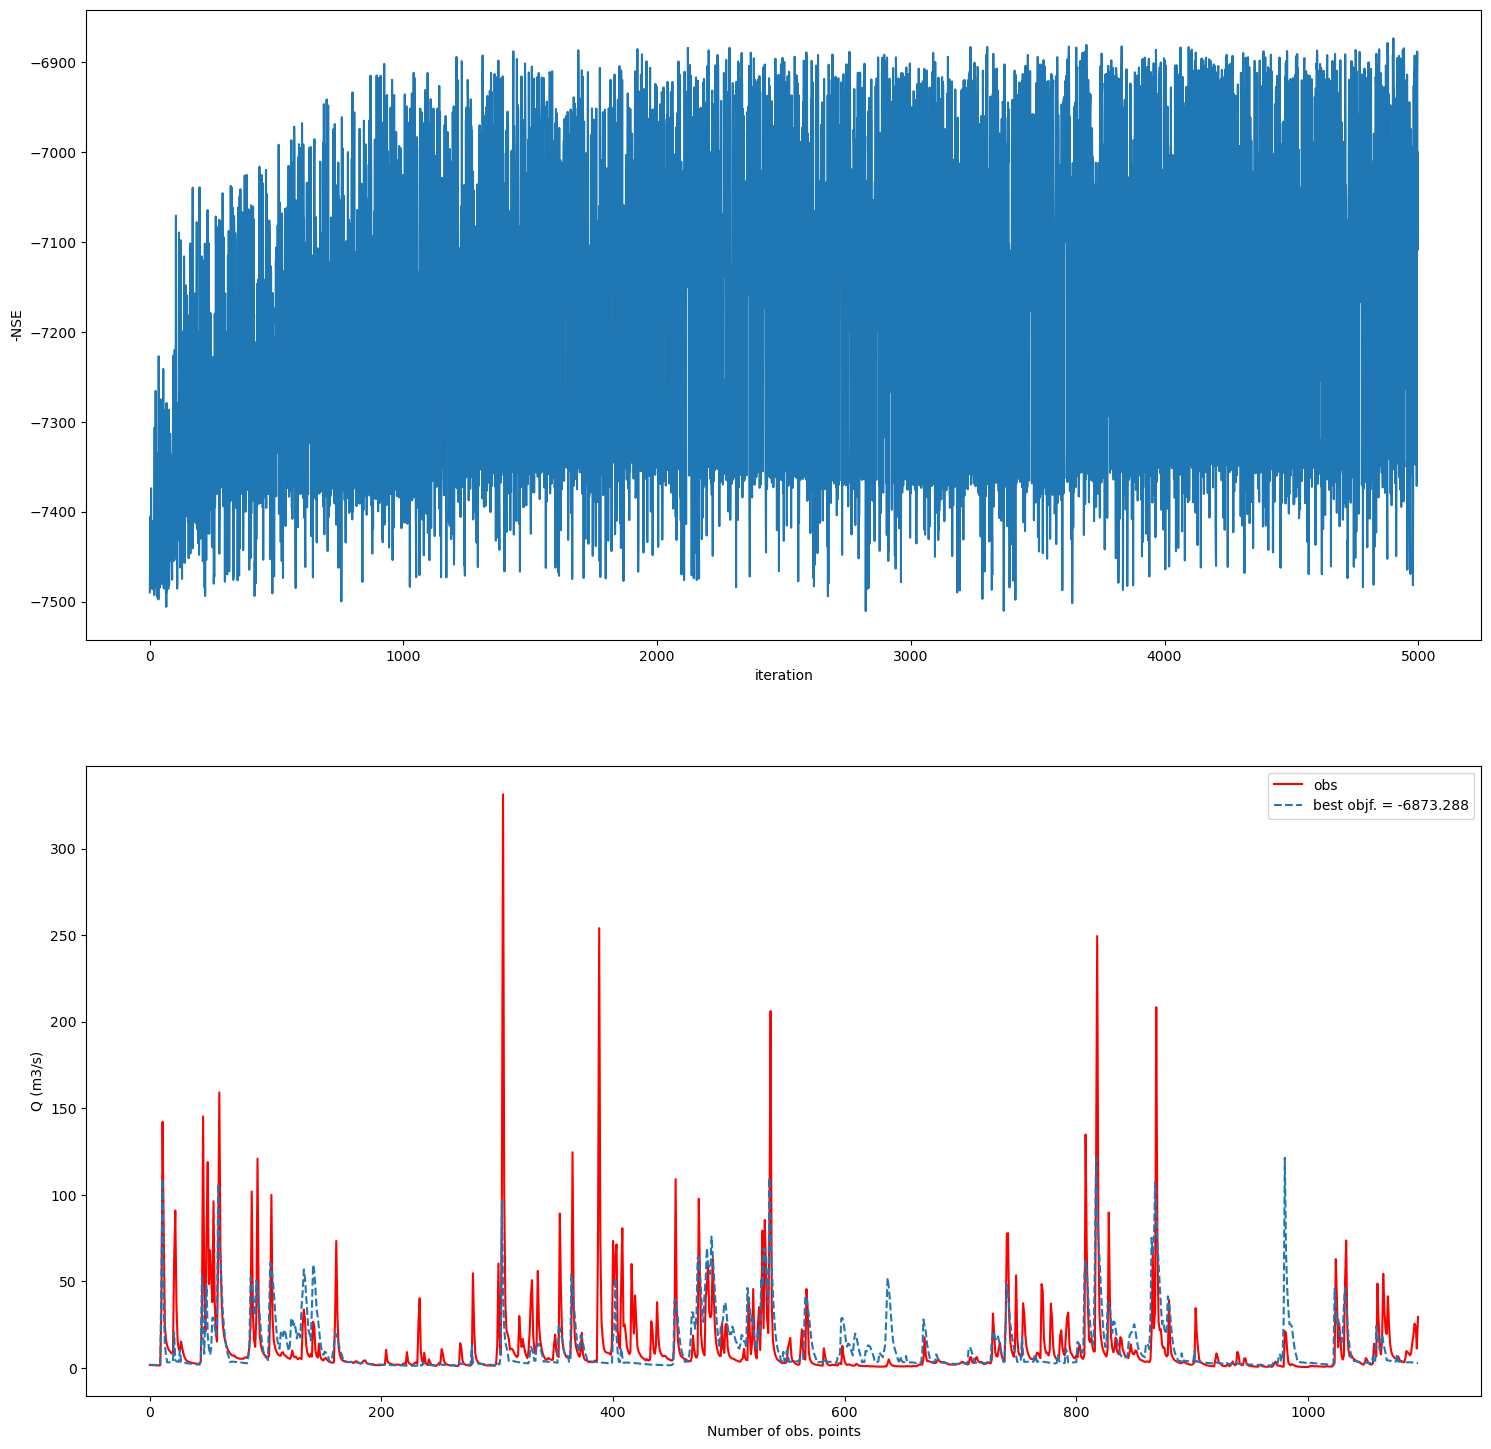

In [18]:
Cal_results = sp.analyser.load_csv_results("Cal")
bestindex, bestobjf = sp.analyser.get_maxlikeindex(Cal_results)
bestindex = 302
best_model_run = Cal_results[bestindex]
fields = [word for word in best_model_run.dtype.names if word.startswith("sim")]
best_simulation = np.array(list(best_model_run[fields]))
obs = np.array(spot_setup.evaluation())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,18))
ax1.plot(Cal_results['like1'])
ax1.set_xlabel("iteration")
ax1.set_ylabel("-NSE")

ax2.plot(obs, "r-", label="obs")
ax2.plot(best_simulation, "--", markersize = 2 ,label="best objf. = " + str(bestobjf))
ax2.set_xlabel("Number of obs. points")
ax2.set_ylabel("Q (m3/s)")
ax2.legend()

# Bayseian

In [5]:
Cal_results = sp.analyser.load_csv_results("cal")
fields = [word for word in Cal_results.dtype.names if word.startswith("sim")]
print(Cal_results[fields])

[(0.5047, 0.503, 0.5005, 0.5009, 0.4978, 0.4961, 0.4946, 0.494 , 0.4929, 0.5052,   0.6269,   0.656,  0.5842,  0.5797,  0.5813,  0.5851,  0.5875,  0.5922,  0.5949, 0.5972,  0.6048,  0.6281,  0.6181, 0.6172, 0.6209, 0.6232,  0.6303, 0.6277, 0.6354, 0.636, 0.6373, 0.6388, 0.642, 0.6443, 0.6466, 0.6458, 0.6482, 0.6495, 0.6528, 0.6575, 0.6585, 0.6614, 0.6604, 0.6632,  0.6838,  0.7611,  0.7173,  0.718,  0.7468,  0.7679,  0.7538,  0.7717,  0.7678,  0.7775,  0.7997,  0.7888,  0.7946,  0.799,  0.8162,   0.9185,   0.8572,  0.8634,  0.8695,  0.8752,  0.8801,  0.8859,  0.8936, 0.8983, 0.9052, 0.9068, 0.9125, 0.9234, 0.9249, 0.9317, 0.9352, 0.9399, 0.9415, 0.9462, 0.9611, 0.9588, 0.9623, 0.9668, 0.9674, 0.9746, 0.9742,  0.9968,  0.9889,   1.036,  1.008,  1.013,  1.017,  1.033,  1.06 ,  1.043,  1.046,  1.051,  1.055,  1.059,  1.062, 1.067, 1.068, 1.068, 1.071,  1.105,  1.122,  1.102,  1.107,  1.114,  1.116,  1.119,  1.124,  1.125,  1.128,  1.143,  1.139,  1.139,  1.151,  1.146 ,  1.148,  1.151 , 1.1

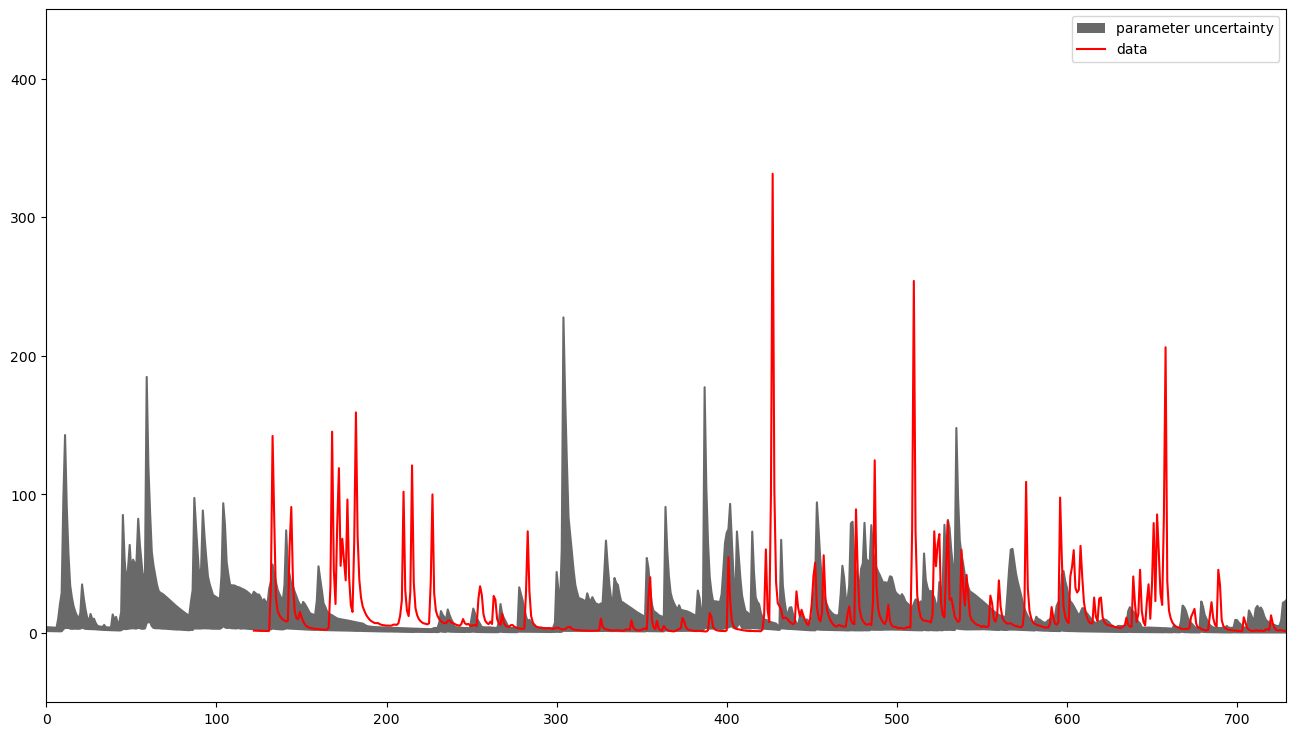

In [7]:
fig = plt.figure(figsize=(16,9))
ax = plt.subplot(1,1,1)
q5,q25,q75,q95=[],[],[],[]
for field in fields:
    q5.append(np.percentile(Cal_results[field][-100:-1],2.5))
    q95.append(np.percentile(Cal_results[field][-100:-1],97.5))
ax.plot(q5,color='dimgrey',linestyle='solid')
ax.plot(q95,color='dimgrey',linestyle='solid')
ax.fill_between(np.arange(0,len(q5),1),list(q5),list(q95),facecolor='dimgrey',zorder=0,
                linewidth=0,label='parameter uncertainty')
ax.plot(spot_setup.evaluation(),'r-',label='data')
ax.set_ylim(-50,450)
ax.set_xlim(0,729)
ax.legend()
fig.savefig('python_hymod.png',dpi=300)

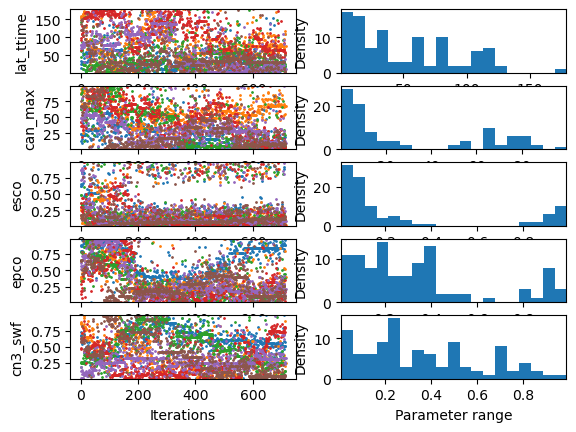

In [17]:
parameters = sp.parameter.get_parameters_array(spot_setup)

fig, ax = plt.subplots(nrows=5, ncols=2)
for par_id in range(5,10):
    sp.analyser.plot_parameter_trace(ax[par_id-5][0], Cal_results, parameters[par_id-5])
    sp.analyser.plot_posterior_parameter_histogram(ax[par_id-5][1], Cal_results, parameters[par_id-5])

ax[-1][0].set_xlabel('Iterations')
ax[-1][1].set_xlabel('Parameter range')

plt.show()
fig.savefig('hymod_parameters.png',dpi=300)

In [14]:
list(range(5, 10))

[5, 6, 7, 8, 9]